In [118]:
import uproot
import mplhep as hep  # matplotlib for hep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak
import dask_awkward
import vector
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
from ROOT import RooRealVar, RooDataSet, RooGaussian, RooArgSet, RooFit, RooCBShape
vector.register_awkward()
ROOT.gSystem.Load("libRooFit")

PURPLE = "\033[95m"
END = "\033[0m"
W_MASS = 80.4  # W boson mass in GeV
LUMI = 50  # Luminosity in pb⁻¹ for given dataset
LUMI_ERR = 0.026
JES_DELTA = 0.02  # Variation in jet 4-momenta for JES systematic
TOP_MASS_MC = 172.5

# path to the root files
path = './root_files/'

neworder = [0, 8, 1, 7, 4, 3, 5, 6, 2]

files = [
    # {"filename": "data.root", "label": "Data", "color": "white"},
    {"filename": "qcd.root", "label": "QCD", "color": "#a9a9a9"},
    {"filename": "wjets.root", "label": "WJets", "color": "#79b278"},
    {"filename": "single_top.root", "label": "Single Top", "color": "#00cdff"},
    {"filename": "ww.root", "label": "WW", "color": "#6b59d3"},
    {"filename": "ttbar.root", "label": "TTbar", "color": "#ff0000"},
    {"filename": "wz.root", "label": "WZ", "color": "orange"},
    {"filename": "zz.root", "label": "ZZ", "color": "#baff8d"},
    {"filename": "dy.root", "label": "DYJets", "color": "#f0f423"}
]

COLUMN_NAMES = [
    "NElectron", "Electron_Px", "Electron_Py", "Electron_Pz", "Electron_Charge", "Electron_Iso",
    "NMuon", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_Charge", "Muon_Iso",
    "NJet", "Jet_Px", "Jet_Py", "Jet_Pz", "Jet_btag",
    "MET_px", "MET_py",
    "EventWeight"
]

TTreeName = "events"
EventWeightBranchName = "EventWeight"

plt.style.use([hep.style.ROOT, hep.style.firamath])
dfs = [uproot.open(path + file["filename"] + ':' + TTreeName) for file in files]
dfs = {}

for file in files:
    tree = uproot.open(path + file["filename"] + ":" + TTreeName)
    dfs[file["label"]] = tree.arrays(COLUMN_NAMES, library = "ak")
    print('opened %s with %d entries as %s' % (file["filename"], len(dfs[file["label"]]), file["label"]))

opened qcd.root with 142 entries as QCD
opened wjets.root with 109737 entries as WJets
opened single_top.root with 5684 entries as Single Top
opened ww.root with 4580 entries as WW
opened ttbar.root with 36941 entries as TTbar
opened wz.root with 3367 entries as WZ
opened zz.root with 2421 entries as ZZ
opened dy.root with 77729 entries as DYJets


In [119]:
# ---- New variable definitions ----

for df in dfs.values():
    df["Muon_Pt"] = np.sqrt(df["Muon_Px"] ** 2 + df["Muon_Py"] ** 2)
    df["MET"] = np.sqrt(df["MET_px"] ** 2 + df["MET_py"] ** 2)

In [120]:
# Returns True if arr is jagged (list per event)
def is_jagged(arr):
    try:
        ak.num(arr, axis = 1)
        return True
    except Exception:
        return False


# Treats Data differently from MC. Automatically adds a ratio plot if Data is present.
def makePlot(
    dfs,
    var,
    xmin = 0,
    xmax = 5,
    step_size = 1,
    ylog = False,
    saveFig = False,
    xlabel = '',
    ylabel = '',
):
    colors = {
        "Data": "white",
        "QCD": "#a9a9a9",
        "WJets": "#79b278",
        "Single Top": "#00cdff",
        "WW": "#6b59d3",
        "TTbar": "#ff0000",
        "WZ": "orange",
        "ZZ": "#baff8d",
        "DYJets": "#f0f423",
    }

    bins = np.arange(xmin, xmax + step_size, step_size)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Separate data and MC
    data_key = None
    mc_keys = []

    for key in dfs:
        if key == "Data":
            data_key = key
        else:
            mc_keys.append(key)

    # Figure layout
    if data_key is not None:
        fig, (ax, rax) = plt.subplots(
            2, 1,
            figsize = (9, 8),
            gridspec_kw = {"height_ratios": [3, 1]},
            sharex = True,
        )
    else:
        fig, ax = plt.subplots(figsize = (9, 6))
        rax = None

    # ---------- MC ----------    
    mc_hists = []
    mc_labels = []
    mc_colors = []

    for key in mc_keys:
        arr = dfs[key][var]
        weights = dfs[key]["EventWeight"]

        # Jagged vs flat
        if is_jagged(arr):
            values = ak.flatten(arr)
            weights = ak.flatten(ak.broadcast_arrays(arr, weights)[1])
        else:
            values = arr

        values = ak.to_numpy(values)
        weights = ak.to_numpy(weights)

        hist, _ = np.histogram(values, bins = bins, weights = weights)

        mc_hists.append(hist)
        mc_labels.append(key)
        mc_colors.append(colors.get(key, "gray"))

    mc_hists = np.array(mc_hists)
    mc_sum = np.sum(mc_hists, axis = 0)
    bottom = np.zeros(len(bins) - 1)

    for hist, label, color in zip(mc_hists, mc_labels, mc_colors):
        ax.bar(
            bin_centers,
            hist,
            width = step_size,
            bottom = bottom,
            color = color,
            edgecolor = "black",
            linewidth = 0.5,
            label = label,
            align = "center",
        )
        bottom += hist

    # ---------- Data ----------
    if data_key is not None:
        arr = dfs[data_key][var]
        weights = dfs[data_key]["EventWeight"]

        if is_jagged(arr):
            values = ak.flatten(arr)
            weights = ak.flatten(ak.broadcast_arrays(arr, weights)[1])
        else:
            values = arr

        values = ak.to_numpy(values)
        weights = ak.to_numpy(weights)

        data_hist, _ = np.histogram(values, bins = bins, weights = weights)
        data_err = np.sqrt(data_hist)

        ax.errorbar(
            bin_centers,
            data_hist,
            yerr = data_err,
            fmt = "o",
            color = "black",
            label = "Data",
            zorder = 10,
        )

    # ---------- Styling ----------
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel(ylabel if ylabel else "Events")

    if ylog:
        ax.set_yscale("log")
        ax.set_ylim(bottom = 0.1)

    legend_handles = []
    
    # MC entries
    for label, color in zip(mc_labels, mc_colors):
        legend_handles.append(
            Patch(facecolor = color, edgecolor = "black", label = label)
        )
    
    # Data entry
    if data_key is not None:
        legend_handles.append(
            Line2D(
                [0], [0],
                marker = "o",
                color = "black",
                linestyle = "none",
                label = "Data",
            )
        )
    
    ax.legend(
        handles = legend_handles,
        loc = "upper left",
        bbox_to_anchor = (1.02, 1.0),
        borderaxespad = 0.0,
        fontsize = 14
    )

    ax.text(
        0.7,
        0.95,
        "CMS Preliminary",
        transform = ax.transAxes,
        fontsize = 12,
        verticalalignment = "top",
    )

    # ---------- Ratio ----------
    if rax is not None:
        ratio = np.zeros_like(mc_sum, dtype = float)
        ratio_err = np.zeros_like(mc_sum, dtype = float)

        mask = mc_sum > 0
        ratio[mask] = data_hist[mask] / mc_sum[mask]
        ratio_err[mask] = np.sqrt(data_hist[mask]) / mc_sum[mask]

        rax.errorbar(
            bin_centers,
            ratio,
            yerr = ratio_err,
            fmt = "o",
            color = "black",
        )

        rax.axhline(1.0, color = "red", linestyle = "--", linewidth = 1)
        rax.set_ylim(0.5, 1.5)
        rax.set_ylabel("Data / MC")
        rax.set_xlabel(xlabel if xlabel else var)
    else:
        ax.set_xlabel(xlabel if xlabel else var)

    plt.tight_layout()

    if saveFig:
        plt.savefig(saveFig, dpi = 300)

    plt.show()


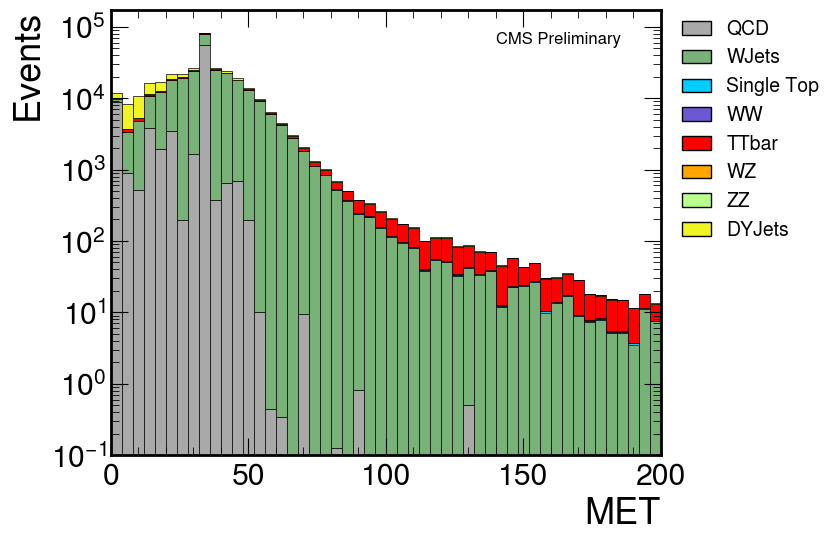

In [124]:
makePlot(dfs, var = 'MET', xmin = 0, xmax = 200, step_size = 4, ylog = True, saveFig = False)

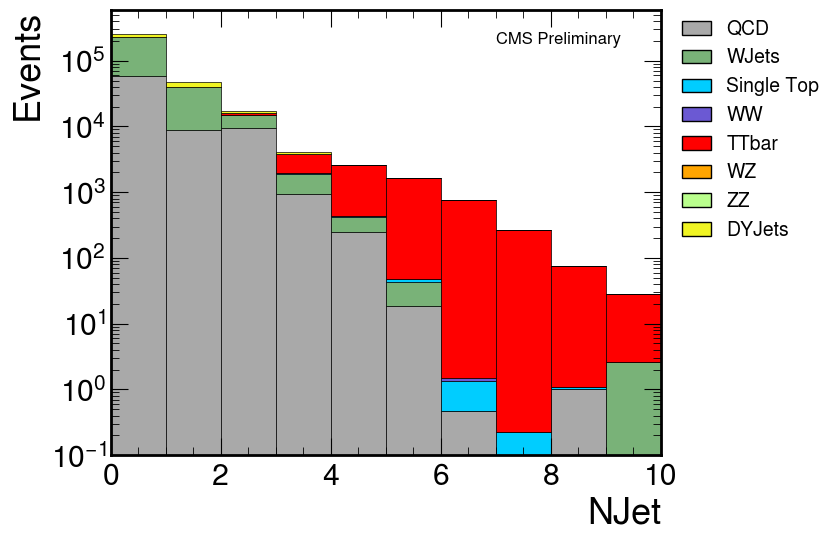

In [125]:
makePlot(dfs, var = 'NJet', xmin = 0, xmax = 10, step_size = 1, ylog = True, saveFig = False)

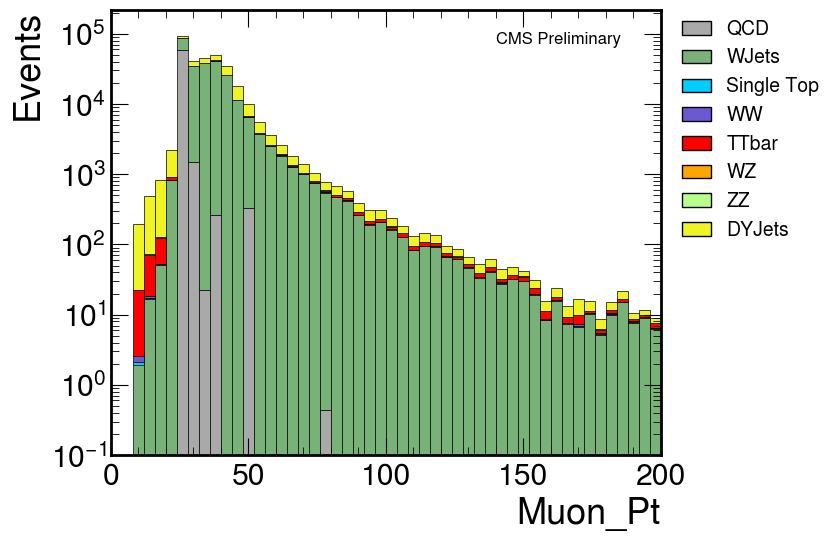

In [126]:
makePlot(dfs, var = 'Muon_Pt', xmin = 0, xmax = 200, step_size = 4, ylog = True, saveFig = False)